In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/animal_dataset/'

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
resnet50 = models.resnet50(pretrained=True)
feature_extractor = nn.Sequential(*list(resnet50.children())[:-1])  # Remove FC layer
feature_extractor.eval()
feature_extractor.cuda()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
def extract_features(dataloader, model):
    features = []
    labels = []
    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.cuda()
            output = model(imgs)
            output = output.view(output.size(0), -1)  # Flatten to (batch_size, 2048)
            features.append(output.cpu())
            labels.append(lbls)
    return torch.cat(features), torch.cat(labels)

In [ ]:
features, labels = extract_features(dataloader, feature_extractor)

In [ ]:
torch.save(features, 'animal_features.pt')
torch.save(labels, 'animal_labels.pt')


In [ ]:
print("Feature extraction complete. Features shape:", features.shape)

Feature extraction complete. Features shape: torch.Size([936, 2048])


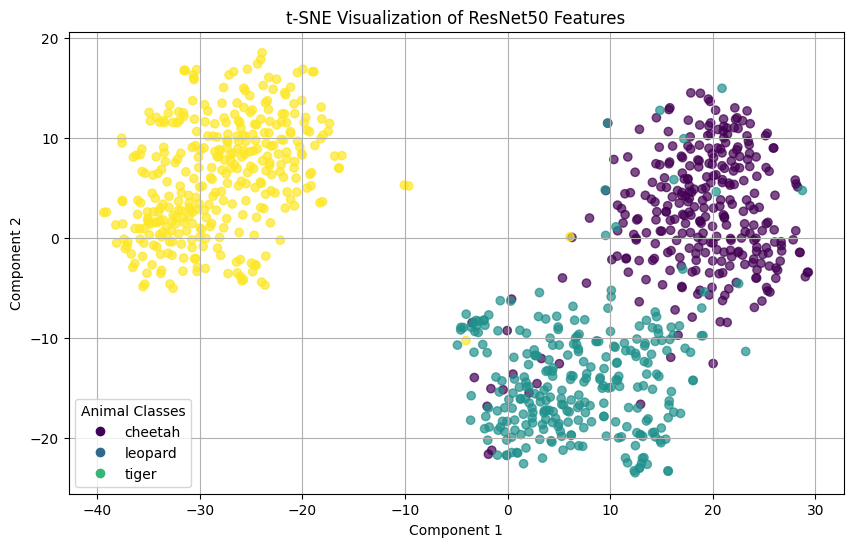

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Convert to numpy
features_np = features.numpy()
labels_np = labels.numpy()

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features_np)

# Plot with class labels
plt.figure(figsize=(10, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_np, cmap='viridis', alpha=0.7)

# Add legend with actual class names
class_names = dataset.classes  # ['cheetah', 'leopard', 'tiger']
handles = []
for i, class_name in enumerate(class_names):
    handles.append(plt.Line2D([], [], marker='o', linestyle='', color=plt.cm.viridis(i / len(class_names)), label=class_name))
plt.legend(handles=handles, title='Animal Classes')

plt.title("t-SNE Visualization of ResNet50 Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()
